In [1]:
import pandas as pd
import os

dataset_path = '/kaggle/input/rockpaperscissors/rps-cv-images'

images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
        
df = pd.DataFrame({'image': images, 'label': labels})

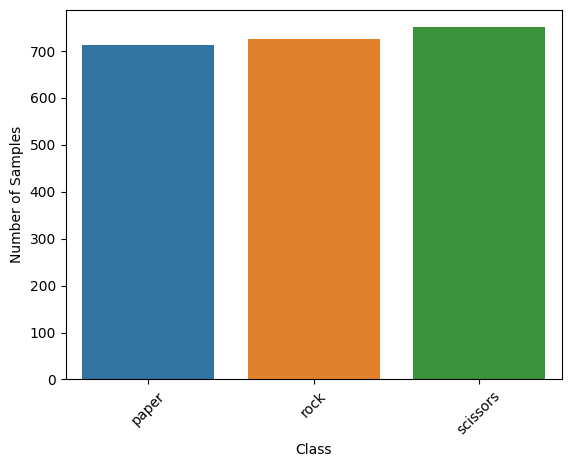

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the classes
ax = sns.countplot(x=df.label)
ax.set_xlabel("Class")
ax.set_ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

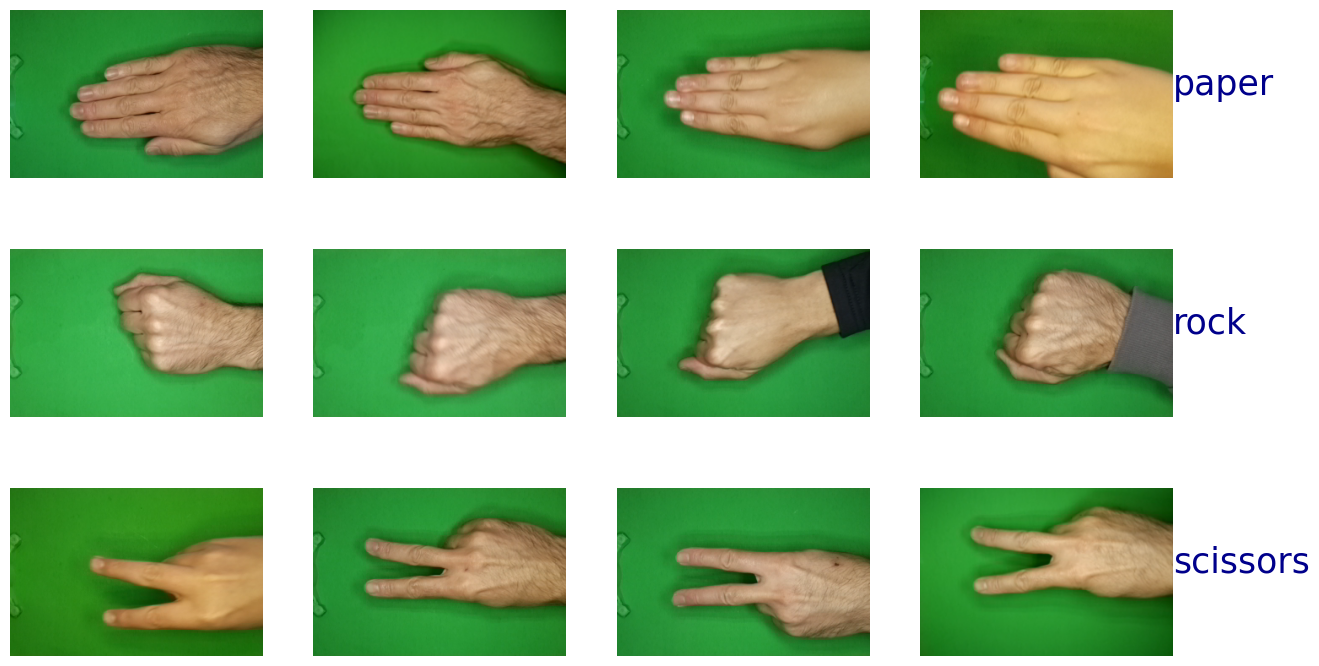

In [3]:
from matplotlib.gridspec import GridSpec

# Create figure and grid of subplots
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

# Loop through each unique category in the DataFrame
for i, category in enumerate(df['label'].unique()):
    filepaths = df[df['label'] == category]['image'].values[:4]
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    ax.text(300, 100, category, fontsize=25, color='darkblue')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split dataset into train and val
X_train, X_val, y_train, y_val = train_test_split(df['image'], df['label'], test_size=0.4, random_state=42)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.fit_transform(y_val)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# Create data augmentation options for image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255)

# Create generator for train and val data
train = train_datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=(50, 50),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

val = val_datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=(50, 50),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

2024-05-07 00:17:42.064744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 00:17:42.065094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 00:17:42.250653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1312 validated image filenames belonging to 3 classes.
Found 876 validated image filenames belonging to 3 classes.


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create sequential model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [7]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
import tensorflow as tf

# Save best model
callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_keras', 
                                               verbose=2, 
                                               save_best_only=True, 
                                               monitor='val_accuracy',
                                               mode='max')

# Train model
history = model.fit(train, epochs=20, validation_data=val, verbose=2, callbacks=[callbacks])

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.48630, saving model to best_model_keras
21/21 - 29s - loss: 1.0846 - accuracy: 0.3834 - val_loss: 1.0314 - val_accuracy: 0.4863 - 29s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.48630 to 0.90868, saving model to best_model_keras
21/21 - 14s - loss: 0.8991 - accuracy: 0.5762 - val_loss: 0.3766 - val_accuracy: 0.9087 - 14s/epoch - 666ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.90868 to 0.93379, saving model to best_model_keras
21/21 - 13s - loss: 0.6421 - accuracy: 0.7218 - val_loss: 0.2567 - val_accuracy: 0.9338 - 13s/epoch - 596ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.93379 to 0.96461, saving model to best_model_keras
21/21 - 14s - loss: 0.5547 - accuracy: 0.7805 - val_loss: 0.2156 - val_accuracy: 0.9646 - 14s/epoch - 661ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.96461
21/21 - 11s - loss: 0.4997 - accuracy: 0.8102 - val_loss: 0.1794 - val_accuracy: 0.9566

<function matplotlib.pyplot.show(close=None, block=None)>

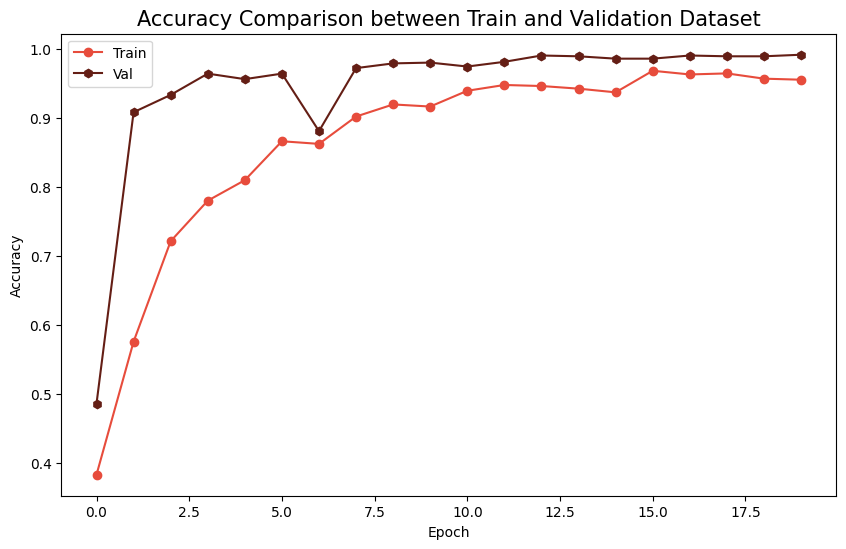

In [9]:
# Plot accuracy comparison
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'],color="#E74C3C",marker='o')
plt.plot(history.history['val_accuracy'],color="#641E15",marker='h')
plt.title('Accuracy Comparison between Train and Validation Dataset',fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

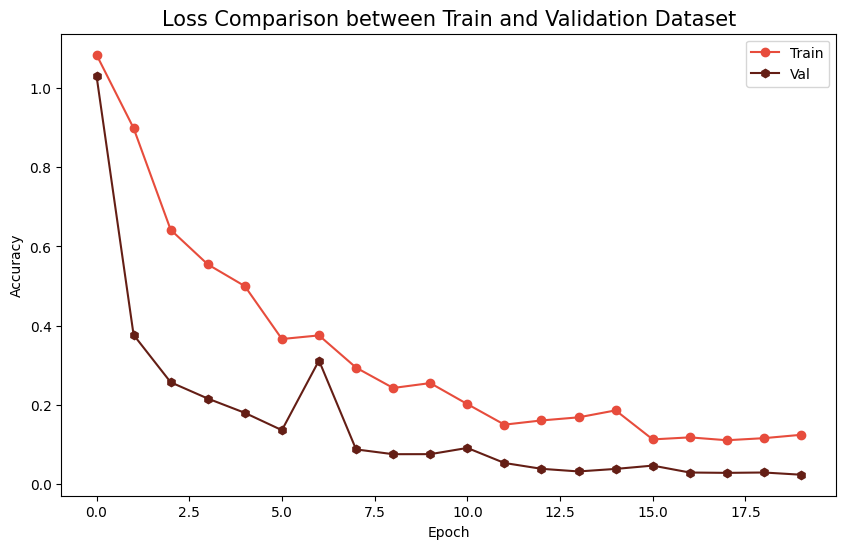

In [10]:
# Plot loss comparison
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],color="#E74C3C",marker='o')
plt.plot(history.history['val_loss'],color="#641E15",marker='h')
plt.title('Loss Comparison between Train and Validation Dataset',fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show

In [11]:
model.save('CNN_model.keras')
print("Model saved succesfully!")

Model saved succesfully!
